# Classificação

# MNIST

Este sera o dataset análisado, consiste em algorimos escritos a mão, o objetivo desse projeto será prever qual algorismo é este com base nos dados.

In [4]:
from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

#importando o dataset
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
#Separando as variaveis independentes e a variavel dependete
X, y = mnist["data"], mnist["target"].astype(np.uint8)
X.shape

(70000, 784)

Como podemos perceber, temos 70 mil observações e cada uma possui 784 características. pois são imagens de 28 x 28 pixels, como podemos visualizar pela imagem abaixo:

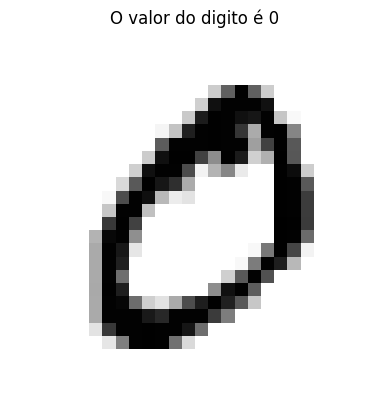

In [45]:
digito = np.array(X.iloc[1])
digito_imagem = digito.reshape(28, 28)

plt.imshow(digito_imagem, cmap='binary')
plt.title(f'O valor do digito é {y[1]}')
plt.axis('off')
plt.show()

In [7]:
X_train, X_test, y_train, y_test = tts(X, y, train_size = 0.857142857)

# Treinando um classificador binario

vamos começar simplificando o problema, classificando apenas se o númeor é um 5 ou não

In [8]:
# Criando um vetor com true para valores iguais a 5 e false, caso contrario
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

# Avaliando um modelo de classificação

Existem diversas formas de avaliar um modelo de classificação e algumas serão apresentadas a seguir

## Acuracia através da validação cruzada

Para isso utilizaremos a função presente no sklearn cross_val_score(), que divide o dataset em k_folds e treina modelos para predizer

In [10]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9686    , 0.9547    , 0.96349817])

Uma acuracia minima de 94% chama atenção, mas o dataset esta desbalenceado, com 10% das amostras sendo 5, assim caso o modelo chutasse tudo como não 5, teria uma acuracia de 90%

## Matriz de Confusão

Permite que tenhamos uma melhor ideia do desempenho do programa, assim podemos verificar os falsos positivos e falsos negativos. para fazer as predições utilizaremos o cross_val_predict(), que faz a mesma coisa que o cross_val_score(), mas retorna as predições através de validação cruzada ao invés das acuracias.

Para entendermos os resultados devemos entender que os valores na horizontal são os reais e os na vertical são os previstos, sendo assim a diagonal central mostra as predições corretas, e o canto superior direito é os falsos positivos e os canto inferior direito são os falsos positivos.

In [11]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

<AxesSubplot:>

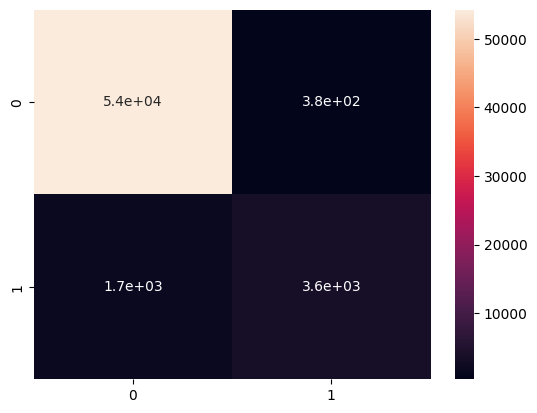

In [12]:
heatmap(confusion_matrix(y_train_5, y_train_pred), annot=True)

A partir das matrizes de confusão podemos tirar algumas outras métricas para a análise:

- Precisão: $\frac{TP}{TP+FP}$, com TP sendo o número de verdadeiros positivos e FP o número de falsos verdadeiros. Essa métrica pode ser burlada, caso haja apenas uma medida verdadeira, e ela esteja correta. Por isso essa medida é sempre apresentada em conjunto com a revocação.

- Revocação: $\frac{TP}{TP+FN}$, com FN sendo falso negativo, isso previne o caso descrito anteriormente, pois caso ele ocorra a revocação vai ser baixa, alertando para algo errado no modelo.

O scikir-learn oferece funções para calcularmos essas metricas de forma simples, como mostrado no código abaixo:

In [13]:
print(f'A precisão foi de {precision_score(y_train_5, y_train_pred)}')
print(f'A revocação foi de {recall_score(y_train_5, y_train_pred)}')

A precisão foi de 0.9050334738408133
A revocação foi de 0.678817184303515


Ou seja, o preditor so acerta 84% quando diz que é um 5 e so detecta 77% dos 5. O resultado ja não parece tão bom.

Para fazer essa análise é importante que você considere as duas métricas e para isso existe o F1 score, que é a média harmônica da revocação e da precisão. Essa métrica é sensivel a valores baixos, com esses impactando muito o resultado, dando vantagem a valores altos. Também beneficia valores semelhante de precisão e revocação, algo que nem sempre é benéfico.
$$ F_1 = \frac{2}{\frac{1}{precisão}+\frac{1}{revocação}}$$

In [14]:
print(f'O f1 foi de {f1_score(y_train_5, y_train_pred)}')

O f1 foi de 0.7757704569606803


## Trade-off precisão-revocação

Infelizmente, caso aumente a precisão a revocação cai, e vice versa. Isso acontece pois ele calcula um score e em uma funçao de decisão, caso esse score seja meno que o limiar ele retorna negativo e no inverso ele retorna positivo. Variando esse limiar é possivel alterar os valores de precisão e revocação. Podemos ver isso utilizando a precision_recal_curve() uma função do sklearn:

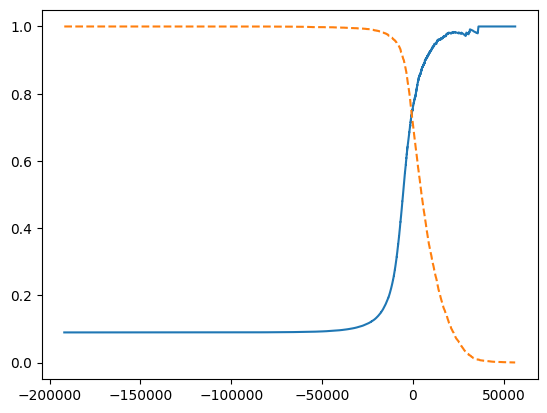

In [15]:
#diferente dos das validações cruzadas anteriormente utilizamos o method para especificar que queremos os scores da funçao de decisão
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(thresholds, precisions[:-1], '-', label='precisão')
plt.plot(thresholds, recalls[:-1], '--', label='revocação')
plt.show()

## Curva ROC

Representa a taxa de verdadeiros positivos pela taxa de falsos positivos ($1-taxa\ de\ verdadeiros\ negativos$). Portanto acurva ROC representa a _sensibilidade_(revocação) versus $1-especificidade$.

O trade-off é quanto maior a revocação, maior a taxa de falsos positivos, devido ao crescimento do threshold do modelo. Para efeito de comparação podemos utilizar a área de baixo da curva ROC, quanto maior melhor

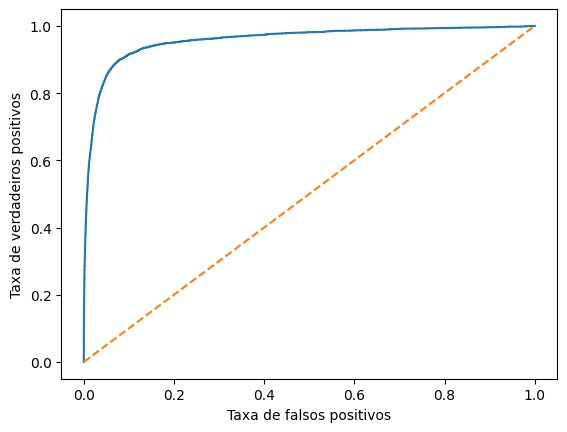

In [28]:
tvp, tpf, thresholds = roc_curve(y_train_5, y_scores)
plt.plot(tvp, tpf, '-', label=None)
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taxa de falsos positivos")
plt.ylabel("Taxa de verdadeiros positivos")
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score

print(f"a área de baixo da curva é de {roc_auc_score(y_train_5, y_scores)}")

a área de baixo da curva é de 0.9585670185013822


# Trinando um novo modelo

Para efeitos de comparação, vamos treinar uma RandomForest e comaparar os resultados.

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
y_proba_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

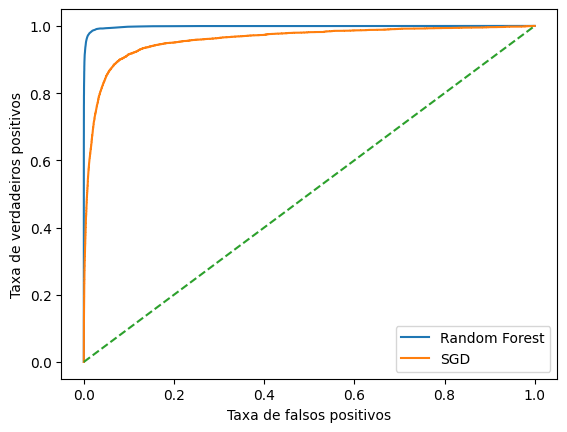

In [39]:
y_score_forest = y_proba_forest[:,1] #score = probabilidade de ser positivo
tvp_forest, tpf_forest, thresholds_forest = roc_curve(y_train_5, y_score_forest)
plt.plot(tvp_forest, tpf_forest, "-", label="Random Forest")
plt.plot(tvp, tpf, '-', label="SGD")
plt.plot([0,1],[0,1], '--')
plt.xlabel("Taxa de falsos positivos")
plt.ylabel("Taxa de verdadeiros positivos")
plt.legend(loc="lower right")
plt.show()

In [40]:
print(f"a área de baixo da curva SGD é de {roc_auc_score(y_train_5, y_scores)} e da curva da Random Forest {roc_auc_score(y_train_5, y_score_forest)}")

a área de baixo da curva SGD é de 0.9585670185013822 e da curva da Random Forest 0.9982993828441921


# Classificação multiclasse

Diferente dos classficadores binarios, podemos usar outros para classificar múltiplas classes.

Alguns podem fazer isso naturalmente, mas outros são apenas classificadores binários, sendo necessário a aplicação de algumas técnicas para torna-los multiclasse. O treinamento é feito da mesma forma que os binarios.

## OVR (One vesrsus the rest)

Cria um classificador para cada classe e escolhe o maior valor de score para retornar. Esse modelo é bom para modelos com um bom escalonomento, evitando o treinamento de muitos modelos no OvO

## OvO (One versus One)

Cria um classficador para cada combinação de classes. É prefirivel utilizar quando o modelo não escala bem, pois compara grupos menores.

In [52]:
rd_multi = RandomForestClassifier()
rd_multi.fit(X_train, y_train)

RandomForestClassifier()

In [53]:
rd_multi.predict([digito])

/home/rafa/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0], dtype=uint8)

In [55]:
rd_multi.predict_proba([digito])

/home/rafa/.local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.99, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ]])

## Analisando o erro

Podemos utilizar a matriz de confusão para análisar o erro, mas isso acaba gerando muitos números e gerando confusão na hora da finalização. Para se ter uma melhor visualização podemos zerar a coluna central e dividir cada valor pela quantidade de observações da classe, evitando que classes com mais observações sejam prejudicadas.

In [58]:
y_train_pred_multi = cross_val_predict(rd_multi, X_train, y_train, cv=3)

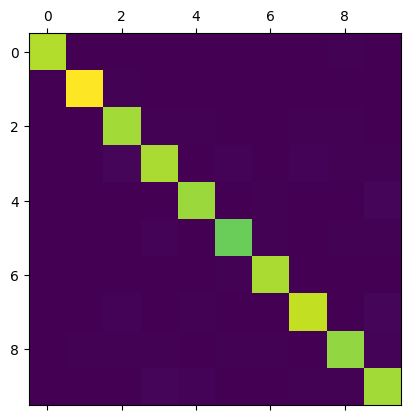

In [59]:
conf_mat = confusion_matrix(y_train, y_train_pred_multi)
plt.matshow(conf_mat)

In [60]:
row_sum = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat/row_sum

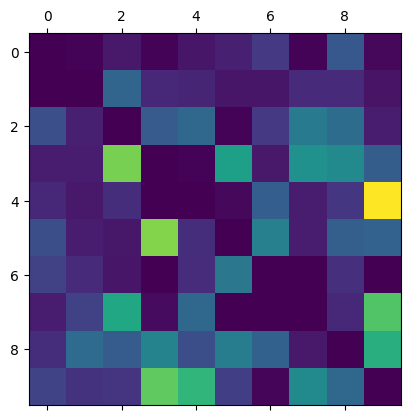

In [61]:
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat)